In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)
import itertools as it
from collections import Counter, defaultdict, deque
import json
import time
import itertools as it
import sys
from tqdm import tqdm
# tqdm.pandas()
from analysis_utils import *
from joblib import Parallel, delayed

# Load data

In [2]:
VERSION = '1.9'
df, pdf = load(VERSION)

# Plot data

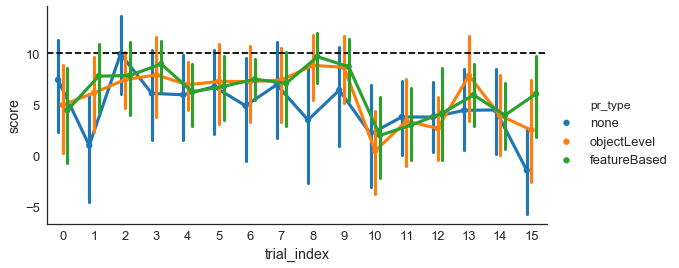

In [27]:
bad = [9359, 7003]
sns.factorplot('trial_index', 'score', hue='pr_type',
               data=df.query('info_cost == 1.25 and trial_id != @bad'),
               dodge=.3, estimator=np.mean, markers='.', aspect=2)
plt.axhline(10, c='k', ls='--')

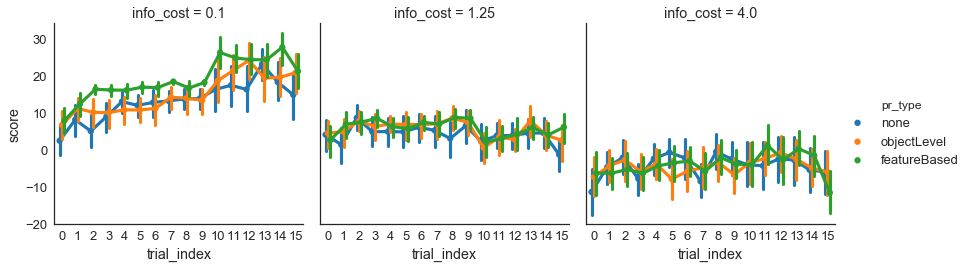

In [4]:
sns.factorplot('trial_index', 'score', hue='pr_type', col='info_cost',
               data=df, dodge=.3, estimator=np.mean, markers='.')

In [6]:
g = df.groupby(['info_cost', 'trial_id']).score
df['score_diff'] = g.apply(lambda x: x - x.mean())
df['score_z'] = g.apply(lambda x: (x - x.mean()) / x.std())

In [7]:
g = df.groupby(['info_cost', 'trial_id']).score
df['score_z'] = g.apply(lambda x: (x - x.mean()) / x.std())
first = df.groupby('pid').score_z.first()
df['score_z_diff'] = df.score_z - first[df.pid].as_matrix()

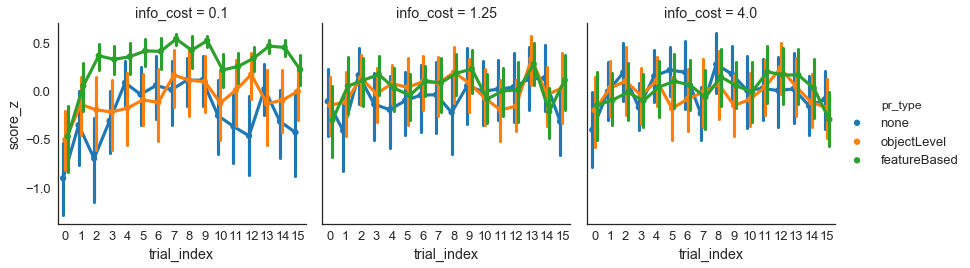

In [8]:
sns.factorplot('trial_index', 'score_z', hue='pr_type', col='info_cost',
               data=df, dodge=.3, estimator=np.mean, markers='.')

In [9]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import ri2py
%load_ext rpy2.ipython

In [10]:
%%R
library(lme4)
library(car)

/usr/local/lib/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)


In [27]:
cols = 'rank info_cost score score_z score_z_diff score_diff trial_index pr_type pid trial_id'.split()
rdf = df[cols].query('info_cost == 1.25')

In [28]:
%%R -i rdf
m = lmer(score ~ pr_type * trial_index + (1|trial_id), data=rdf)
Anova(m)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: score
                     Chisq Df Pr(>Chisq)  
pr_type             8.2158  2    0.01644 *
trial_index         4.3464  1    0.03709 *
pr_type:trial_index 0.1887  2    0.90999  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [13]:
%%R -i rdf
m = lm(score_z ~ pr_type * trial_index, data=rdf)
Anova(m)

Anova Table (Type II tests)

Response: score_z
                     Sum Sq   Df F value Pr(>F)
pr_type                4.32    2  2.1766 0.1137
trial_index            1.62    1  1.6311 0.2017
pr_type:trial_index    0.40    2  0.2013 0.8177
Residuals           1929.67 1946               


# Compare to LC

## Meta Regret

In [20]:
ls ../python

Makefile                evolution.py            pilot_prs.ipynb
__pycache__/            evolutionary.ipynb      policies.py
agents.py               exact.py                prs.npy
analysis_utils.py       exp-data/               scratch.ipynb
bandits.py              human_model.ipynb       select_envs.ipynb
bin/                    human_model.py          survey_responses.ipynb
blinkered_bandits.py    meta_bandits.ipynb      utils.py
click_analysis.ipynb    model_utils.py          value_functions.py
data/                   models.py               voi_montecarlo.ipynb
distributions.py        mouselab.py
evaluation.py           oldmouselab dev.ipynb


In [21]:
sys.path.append('../python')
from model_utils import make_env, make_envs
from value_functions import LiederQ
from agents import Agent

In [22]:
def load_qs():
    with open('exp1/static/json/q_weights.json') as f:
        q_weights = json.load(f)
    Qs = {}
    for cost, theta in q_weights.items():
        Q = LiederQ(theta)
        agent = Agent()
        agent.register(make_env(float(cost)))
        agent.register(Q)
        Qs[cost] = Q
    return Qs
        
Qs = load_qs()

In [23]:
env = make_env(0)
def parse_state(state):
    return tuple(env.reward if x == '__' else float(x)
                 for x in state)
def parse_action(action):
    return env.term_action if action == '__TERM_ACTION__' else action

In [24]:
%%time
from joblib import Parallel, delayed
def trial_regret(i, row):
    beliefs = lmap(parse_state, literal_eval(row.beliefs))
    actions = row.clicks + [env.term_action]
    Q = Qs[f'{row.info_cost:.2f}']

    def regret(s, a):
        q = Q.predict(s)
        return q.max() - q[a]

    return sum(regret(s, a) for s, a in zip(beliefs, actions))

def parallel_apply(df, func):
    jobs = (delayed(func)(i, row) for i, row in df.iterrows())
    return Parallel(n_jobs=-2)(jobs)

df['regret'] = parallel_apply(df['beliefs info_cost clicks'.split()], trial_regret)
df['performance'] = -df.regret

JoblibContractNotRespected: JoblibContractNotRespected
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x107362db0, file "/usr...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/miniconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/l.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x107362db0, file "/usr...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/miniconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/l.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "%%time\nfrom joblib import Parallel, delayed\ndef ...()], trial_regret)\ndf['performance'] = -df.regret", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 25, 20, 48, 38, 363551, tzinfo=tzutc()), 'msg_id': '96E905D6380F4B20A094CF19DFE6801D', 'msg_type': 'execute_request', 'session': 'DB85CD4ED5224D289B356CCC5D1FFD71', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '96E905D6380F4B20A094CF19DFE6801D', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'DB85CD4ED5224D289B356CCC5D1FFD71']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "%%time\nfrom joblib import Parallel, delayed\ndef ...()], trial_regret)\ndf['performance'] = -df.regret", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 25, 20, 48, 38, 363551, tzinfo=tzutc()), 'msg_id': '96E905D6380F4B20A094CF19DFE6801D', 'msg_type': 'execute_request', 'session': 'DB85CD4ED5224D289B356CCC5D1FFD71', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '96E905D6380F4B20A094CF19DFE6801D', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'DB85CD4ED5224D289B356CCC5D1FFD71'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "%%time\nfrom joblib import Parallel, delayed\ndef ...()], trial_regret)\ndf['performance'] = -df.regret", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 25, 20, 48, 38, 363551, tzinfo=tzutc()), 'msg_id': '96E905D6380F4B20A094CF19DFE6801D', 'msg_type': 'execute_request', 'session': 'DB85CD4ED5224D289B356CCC5D1FFD71', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '96E905D6380F4B20A094CF19DFE6801D', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="%%time\nfrom joblib import Parallel, delayed\ndef ...()], trial_regret)\ndf['performance'] = -df.regret", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "%%time\nfrom joblib import Parallel, delayed\ndef ...()], trial_regret)\ndf['performance'] = -df.regret"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("%%time\nfrom joblib import Parallel, delayed\ndef ...()], trial_regret)\ndf['performance'] = -df.regret",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("%%time\nfrom joblib import Parallel, delayed\ndef ...()], trial_regret)\ndf['performance'] = -df.regret",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="%%time\nfrom joblib import Parallel, delayed\ndef ...()], trial_regret)\ndf['performance'] = -df.regret", store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-24-63c09c3cb977>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 12145d6d8, execution_..._before_exec=None error_in_exec=None result=None>)
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])
   2807                 code = compiler(mod, cell_name, "single")
-> 2808                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x121426030, file "<ipython-input-24-63c09c3cb977>", line 1>
        result = <ExecutionResult object at 12145d6d8, execution_..._before_exec=None error_in_exec=None result=None>
   2809                     return True
   2810 
   2811             # Flush softspace
   2812             if softspace(sys.stdout, 0):

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x121426030, file "<ipython-input-24-63c09c3cb977>", line 1>, result=<ExecutionResult object at 12145d6d8, execution_..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x121426030, file "<ipython-input-24-63c09c3cb977>", line 1>
        self.user_global_ns = {'Agent': <class 'agents.Agent'>, 'Counter': <class 'collections.Counter'>, 'In': ['', "get_ipython().magic('matplotlib inline')\n\nimport...ils import *\nfrom joblib import Parallel, delayed", 'def load(v):\n    """Loads data from experiment w...a = df.pr_data.fillna(\'None\').apply(literal_eval)', 'def load(v):\n    """Loads data from experiment w...a = df.pr_data.fillna(\'None\').apply(literal_eval)', "df['rank'] = df.groupby(['info_cost', 'trial_id']).score.rank(pct=True)", "sns.factorplot('trial_index', 'score', hue='pr_t...ata=df, dodge=.3, estimator=np.mean, markers='.')", "g = df.groupby(['info_cost', 'trial_id']).score\n...z'] = g.apply(lambda x: (x - x.mean()) / x.std())", "g = df.groupby(['info_cost', 'trial_id']).score\n...z_diff'] = df.score_z - first[df.pid].as_matrix()", "sns.factorplot('trial_index', 'score_z', hue='pr...ata=df, dodge=.3, estimator=np.mean, markers='.')", "import rpy2.robjects as ro\nfrom rpy2.robjects im...i2py\nget_ipython().magic('load_ext rpy2.ipython')", r"get_ipython().run_cell_magic('R', '', 'library(lme4)\nlibrary(car)')", "cols = 'rank info_cost score score_z score_z_dif...split()\nrdf = df[cols].query('info_cost == 1.25')", r"get_ipython().run_cell_magic('R', '-i rdf', 'm =...trial_index + (1|trial_id), data=rdf)\nAnova(m)')", r"get_ipython().run_cell_magic('R', '-i rdf', 'm =..._z ~ pr_type * trial_index, data=rdf)\nAnova(m)')", r"get_ipython().run_cell_magic('R', '-i rdf', 'm =...pe * trial_index + (1|pid), data=rdf)\nAnova(m)')", "sys.path.append('../mcrl/')\nfrom model_utils imp...functions import LiederQ\nfrom agents import Agent", "sys.path.append('../mcrl/python')\nfrom model_uti...functions import LiederQ\nfrom agents import Agent", "get_ipython().magic('ls ../mcrl/python')", "get_ipython().magic('ls .')", "get_ipython().magic('ls ../')", ...], 'Labeler': <class 'utils.Labeler'>, 'LiederQ': <class 'value_functions.LiederQ'>, 'Out': {5: <seaborn.axisgrid.FacetGrid object>, 8: <seaborn.axisgrid.FacetGrid object>}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'PriorityQueue': <class 'utils.PriorityQueue'>, 'Qs': {'0.10': <value_functions.LiederQ object>, '1.25': <value_functions.LiederQ object>, '4.00': <value_functions.LiederQ object>}, 'VERSION': '1.9', ...}
        self.user_ns = {'Agent': <class 'agents.Agent'>, 'Counter': <class 'collections.Counter'>, 'In': ['', "get_ipython().magic('matplotlib inline')\n\nimport...ils import *\nfrom joblib import Parallel, delayed", 'def load(v):\n    """Loads data from experiment w...a = df.pr_data.fillna(\'None\').apply(literal_eval)', 'def load(v):\n    """Loads data from experiment w...a = df.pr_data.fillna(\'None\').apply(literal_eval)', "df['rank'] = df.groupby(['info_cost', 'trial_id']).score.rank(pct=True)", "sns.factorplot('trial_index', 'score', hue='pr_t...ata=df, dodge=.3, estimator=np.mean, markers='.')", "g = df.groupby(['info_cost', 'trial_id']).score\n...z'] = g.apply(lambda x: (x - x.mean()) / x.std())", "g = df.groupby(['info_cost', 'trial_id']).score\n...z_diff'] = df.score_z - first[df.pid].as_matrix()", "sns.factorplot('trial_index', 'score_z', hue='pr...ata=df, dodge=.3, estimator=np.mean, markers='.')", "import rpy2.robjects as ro\nfrom rpy2.robjects im...i2py\nget_ipython().magic('load_ext rpy2.ipython')", r"get_ipython().run_cell_magic('R', '', 'library(lme4)\nlibrary(car)')", "cols = 'rank info_cost score score_z score_z_dif...split()\nrdf = df[cols].query('info_cost == 1.25')", r"get_ipython().run_cell_magic('R', '-i rdf', 'm =...trial_index + (1|trial_id), data=rdf)\nAnova(m)')", r"get_ipython().run_cell_magic('R', '-i rdf', 'm =..._z ~ pr_type * trial_index, data=rdf)\nAnova(m)')", r"get_ipython().run_cell_magic('R', '-i rdf', 'm =...pe * trial_index + (1|pid), data=rdf)\nAnova(m)')", "sys.path.append('../mcrl/')\nfrom model_utils imp...functions import LiederQ\nfrom agents import Agent", "sys.path.append('../mcrl/python')\nfrom model_uti...functions import LiederQ\nfrom agents import Agent", "get_ipython().magic('ls ../mcrl/python')", "get_ipython().magic('ls .')", "get_ipython().magic('ls ../')", ...], 'Labeler': <class 'utils.Labeler'>, 'LiederQ': <class 'value_functions.LiederQ'>, 'Out': {5: <seaborn.axisgrid.FacetGrid object>, 8: <seaborn.axisgrid.FacetGrid object>}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'PriorityQueue': <class 'utils.PriorityQueue'>, 'Qs': {'0.10': <value_functions.LiederQ object>, '1.25': <value_functions.LiederQ object>, '4.00': <value_functions.LiederQ object>}, 'VERSION': '1.9', ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/Users/fred/Projects/mcrl/experiments/<ipython-input-24-63c09c3cb977> in <module>()
----> 1 get_ipython().run_cell_magic('time', '', "from joblib import Parallel, delayed\ndef trial_regret(i, row):\n    beliefs = lmap(parse_state, literal_eval(row.beliefs))\n    actions = row.clicks + [env.term_action]\n    Q = Qs[f'{row.info_cost:.2f}']\n\n    def regret(s, a):\n        q = Q.predict(s)\n        return q.max() - q[a]\n\n    return sum(regret(s, a) for s, a in zip(beliefs, actions))\n\ndef parallel_apply(df, func):\n    jobs = (delayed(func)(i, row) for i, row in df.iterrows())\n    return Parallel(n_jobs=-2)(jobs)\n\ndf['regret'] = parallel_apply(df['beliefs info_cost clicks'.split()], trial_regret)\ndf['performance'] = -df.regret")

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name='time', line='', cell="from joblib import Parallel, delayed\ndef trial_r...()], trial_regret)\ndf['performance'] = -df.regret")
   2098             # This will need to be updated if the internal calling logic gets
   2099             # refactored, or else we'll be expanding the wrong variables.
   2100             stack_depth = 2
   2101             magic_arg_s = self.var_expand(line, stack_depth)
   2102             with self.builtin_trap:
-> 2103                 result = fn(magic_arg_s, cell)
        result = undefined
        fn = <bound method ExecutionMagics.time of <IPython.core.magics.execution.ExecutionMagics object>>
        magic_arg_s = ''
        cell = "from joblib import Parallel, delayed\ndef trial_r...()], trial_regret)\ndf['performance'] = -df.regret"
   2104             return result
   2105 
   2106     def find_line_magic(self, magic_name):
   2107         """Find and return a line magic by name.

...........................................................................
/Users/fred/Projects/mcrl/experiments/<decorator-gen-62> in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell="from joblib import Parallel, delayed\ndef trial_r...()], trial_regret)\ndf['performance'] = -df.regret", local_ns=None)

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/core/magic.py in <lambda>(f=<function ExecutionMagics.time>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, '', "from joblib import Parallel, delayed\ndef trial_r...()], trial_regret)\ndf['performance'] = -df.regret", None), **k={})
    182     validate_type(magic_kind)
    183 
    184     # This is a closure to capture the magic_kind.  We could also use a class,
    185     # but it's overkill for just that one bit of state.
    186     def magic_deco(arg):
--> 187         call = lambda f, *a, **k: f(*a, **k)
        f = <function ExecutionMagics.time>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, '', "from joblib import Parallel, delayed\ndef trial_r...()], trial_regret)\ndf['performance'] = -df.regret", None)
        k = {}
    188 
    189         if callable(arg):
    190             # "Naked" decorator call (just @foo, no args)
    191             func = arg

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/core/magics/execution.py in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell="from joblib import Parallel, delayed\ndef trial_r...()], trial_regret)\ndf['performance'] = -df.regret", local_ns=None)
   1210                 return
   1211             end = clock2()
   1212         else:
   1213             st = clock2()
   1214             try:
-> 1215                 exec(code, glob, local_ns)
        code = <code object <module> at 0x121451f60, file "<timed exec>", line 1>
        glob = {'Agent': <class 'agents.Agent'>, 'Counter': <class 'collections.Counter'>, 'In': ['', "get_ipython().magic('matplotlib inline')\n\nimport...ils import *\nfrom joblib import Parallel, delayed", 'def load(v):\n    """Loads data from experiment w...a = df.pr_data.fillna(\'None\').apply(literal_eval)', 'def load(v):\n    """Loads data from experiment w...a = df.pr_data.fillna(\'None\').apply(literal_eval)', "df['rank'] = df.groupby(['info_cost', 'trial_id']).score.rank(pct=True)", "sns.factorplot('trial_index', 'score', hue='pr_t...ata=df, dodge=.3, estimator=np.mean, markers='.')", "g = df.groupby(['info_cost', 'trial_id']).score\n...z'] = g.apply(lambda x: (x - x.mean()) / x.std())", "g = df.groupby(['info_cost', 'trial_id']).score\n...z_diff'] = df.score_z - first[df.pid].as_matrix()", "sns.factorplot('trial_index', 'score_z', hue='pr...ata=df, dodge=.3, estimator=np.mean, markers='.')", "import rpy2.robjects as ro\nfrom rpy2.robjects im...i2py\nget_ipython().magic('load_ext rpy2.ipython')", r"get_ipython().run_cell_magic('R', '', 'library(lme4)\nlibrary(car)')", "cols = 'rank info_cost score score_z score_z_dif...split()\nrdf = df[cols].query('info_cost == 1.25')", r"get_ipython().run_cell_magic('R', '-i rdf', 'm =...trial_index + (1|trial_id), data=rdf)\nAnova(m)')", r"get_ipython().run_cell_magic('R', '-i rdf', 'm =..._z ~ pr_type * trial_index, data=rdf)\nAnova(m)')", r"get_ipython().run_cell_magic('R', '-i rdf', 'm =...pe * trial_index + (1|pid), data=rdf)\nAnova(m)')", "sys.path.append('../mcrl/')\nfrom model_utils imp...functions import LiederQ\nfrom agents import Agent", "sys.path.append('../mcrl/python')\nfrom model_uti...functions import LiederQ\nfrom agents import Agent", "get_ipython().magic('ls ../mcrl/python')", "get_ipython().magic('ls .')", "get_ipython().magic('ls ../')", ...], 'Labeler': <class 'utils.Labeler'>, 'LiederQ': <class 'value_functions.LiederQ'>, 'Out': {5: <seaborn.axisgrid.FacetGrid object>, 8: <seaborn.axisgrid.FacetGrid object>}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'PriorityQueue': <class 'utils.PriorityQueue'>, 'Qs': {'0.10': <value_functions.LiederQ object>, '1.25': <value_functions.LiederQ object>, '4.00': <value_functions.LiederQ object>}, 'VERSION': '1.9', ...}
        local_ns = None
   1216             except:
   1217                 self.shell.showtraceback()
   1218                 return
   1219             end = clock2()

...........................................................................
/Users/fred/Projects/mcrl/experiments/<timed exec> in <module>()

...........................................................................
/Users/fred/Projects/mcrl/experiments/<timed exec> in parallel_apply(df=                                                ..., 1, 6, 2, 7, 8, 3, 4]  

[5808 rows x 3 columns], func=<function trial_regret>)

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=-2), iterable=<generator object parallel_apply.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ContractNotRespected                               Mon Dec 25 12:48:42 2017
PID: 40388               Python 3.6.3: /usr/local/lib/miniconda3/bin/python
...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function trial_regret>, (56, beliefs      [[0, u'__', u'__', u'__', u'__', u'...[8, 3, 2, 14, 16, 15, 13]
Name: 56, dtype: object), {}), (<function trial_regret>, (57, beliefs      [[0, u'__', u'__', u'__', u'__', u'...[5, 9, 13, 1, 10, 12, 11]
Name: 57, dtype: object), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function trial_regret>
        args = (56, beliefs      [[0, u'__', u'__', u'__', u'__', u'...[8, 3, 2, 14, 16, 15, 13]
Name: 56, dtype: object)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/fred/Projects/mcrl/experiments/<timed exec> in trial_regret(i=56, row=beliefs      [[0, u'__', u'__', u'__', u'__', u'...[8, 3, 2, 14, 16, 15, 13]
Name: 56, dtype: object)

...........................................................................
/Users/fred/Projects/mcrl/experiments/<timed exec> in <genexpr>(.0=<zip object>)

...........................................................................
/Users/fred/Projects/mcrl/experiments/<timed exec> in regret(s=(0.0, Cat, -20.0, 4.0, Cat, Cat, Cat, Cat, -4.0, Cat, Cat, Cat, Cat, Cat, 12.0, 4.0, 4.0), a=13)

...........................................................................
/Users/fred/Projects/mcrl/python/value_functions.py in predict(self=<value_functions.LiederQ object>, state=(0.0, Cat, -20.0, 4.0, Cat, Cat, Cat, Cat, -4.0, Cat, Cat, Cat, Cat, Cat, 12.0, 4.0, 4.0))
     94             return np.dot(self.theta, self.env.action_features(action, state))
     95 
     96     def predict(self, state):
     97         qs = np.full(self.agent.env.action_space.n, -np.inf)
     98         for a in self.env.actions(state):
---> 99             qs[a] = self.predictOne(state, a)
        qs = array([-inf, -inf, -inf, -inf, -inf, -inf, -inf,... -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf])
        a = 1
        self.predictOne = <bound method LiederQ.predictOne of <value_functions.LiederQ object>>
        state = (0.0, Cat, -20.0, 4.0, Cat, Cat, Cat, Cat, -4.0, Cat, Cat, Cat, Cat, Cat, 12.0, 4.0, 4.0)
    100         return qs
    101 
    102 
    103 class NeuralQ(ActionValueFunction):

...........................................................................
/Users/fred/Projects/mcrl/python/value_functions.py in predictOne(self=<value_functions.LiederQ object>, state=(0.0, Cat, -20.0, 4.0, Cat, Cat, Cat, Cat, -4.0, Cat, Cat, Cat, Cat, Cat, 12.0, 4.0, 4.0), action=1)
     89     
     90     def predictOne(self, state, action):
     91         if action == self.env.term_action:
     92             return self.env.expected_term_reward(state)
     93         else:
---> 94             return np.dot(self.theta, self.env.action_features(action, state))
        self.theta = array([ 1.713,  0.464,  0.236,  0.425,  0.993])
        self.env.action_features = <bound method MouselabEnv.action_features of <mouselab.MouselabEnv object>>
        action = 1
        state = (0.0, Cat, -20.0, 4.0, Cat, Cat, Cat, Cat, -4.0, Cat, Cat, Cat, Cat, Cat, 12.0, 4.0, 4.0)
     95 
     96     def predict(self, state):
     97         qs = np.full(self.agent.env.action_space.n, -np.inf)
     98         for a in self.env.actions(state):

...........................................................................
/Users/fred/Projects/mcrl/python/mouselab.py in action_features(self=<mouselab.MouselabEnv object>, action=1, state=(0.0, Cat, -20.0, 4.0, Cat, Cat, Cat, Cat, -4.0, Cat, Cat, Cat, Cat, Cat, 12.0, 4.0, 4.0))
    165                 self.expected_term_reward(state)
    166             ])
    167 
    168         return np.array([
    169             self.cost,
--> 170             self.myopic_voc(action, state),
        self.myopic_voc = <bound method MouselabEnv.myopic_voc of <mouselab.MouselabEnv object>>
        action = 1
        state = (0.0, Cat, -20.0, 4.0, Cat, Cat, Cat, Cat, -4.0, Cat, Cat, Cat, Cat, Cat, 12.0, 4.0, 4.0)
    171             self.vpi_action(action, state),
    172             self.vpi(state),
    173             self.expected_term_reward(state)
    174         ])

...........................................................................
/Users/fred/Projects/mcrl/experiments/<decorator-gen-160> in myopic_voc(self=<mouselab.MouselabEnv object>, action=1, state=(0.0, Cat, -20.0, 4.0, Cat, Cat, Cat, Cat, -4.0, Cat, Cat, Cat, Cat, Cat, 12.0, 4.0, 4.0))

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/contracts/main.py in contracts_checker(unused=<function MouselabEnv.myopic_voc>, *args=(<mouselab.MouselabEnv object>, 1, (0.0, Cat, -20.0, 4.0, Cat, Cat, Cat, Cat, -4.0, Cat, Cat, Cat, Cat, Cat, 12.0, 4.0, 4.0)), **kwargs={})
    259                 returns_parsed._check_contract(context, result, silent=False)
    260             except ContractNotRespected as e:
    261                 msg = ('Breach for return value of %s.\n'
    262                        % (get_nice_function_display()))
    263                 e.error = msg + e.error
--> 264                 raise e
        e = undefined
    265 
    266         return result
    267 
    268     # TODO: add rtype statements if missing

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/contracts/main.py in contracts_checker(unused=<function MouselabEnv.myopic_voc>, *args=(<mouselab.MouselabEnv object>, 1, (0.0, Cat, -20.0, 4.0, Cat, Cat, Cat, Cat, -4.0, Cat, Cat, Cat, Cat, Cat, 12.0, 4.0, 4.0)), **kwargs={})
    254 
    255         result = function_(*args, **kwargs)
    256 
    257         if returns_parsed is not None:
    258             try:
--> 259                 returns_parsed._check_contract(context, result, silent=False)
        context = {'args': (), 'kwargs': {}, 'self': <mouselab.MouselabEnv object>}
        result = -8.0
    260             except ContractNotRespected as e:
    261                 msg = ('Breach for return value of %s.\n'
    262                        % (get_nice_function_display()))
    263                 e.error = msg + e.error

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/contracts/interface.py in _check_contract(self=And([Extension('float'), CheckOrder(None,'>=',Unary('-',SimpleRValue(0.001)))]), context={'args': (), 'kwargs': {}, 'self': <mouselab.MouselabEnv object>}, value=-8.0, silent=False)
    434         if not self._enabled:
    435             return
    436 
    437         variables = context.copy()
    438         try:
--> 439             self.check_contract(context, value, silent)
        self.check_contract = <bound method And.check_contract of And([Extensi...rder(None,'>=',Unary('-',SimpleRValue(0.001)))])>
        context = {'args': (), 'kwargs': {}, 'self': <mouselab.MouselabEnv object>}
        value = -8.0
        silent = False
    440         except ContractNotRespected as e:
    441             e.stack.append((self, variables, value))
    442             raise
    443 

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/contracts/library/compositions.py in check_contract(self=And([Extension('float'), CheckOrder(None,'>=',Unary('-',SimpleRValue(0.001)))]), context={'args': (), 'kwargs': {}, 'self': <mouselab.MouselabEnv object>}, value=-8.0, silent=False)
    118         Logical.__init__(self, AND_GLYPH, 2)
    119         self.clauses = clauses
    120 
    121     def check_contract(self, context, value, silent):
    122         for c in self.clauses:
--> 123             c._check_contract(context, value, silent)
        c._check_contract = <bound method Contract._check_contract of CheckOrder(None,'>=',Unary('-',SimpleRValue(0.001)))>
        context = {'args': (), 'kwargs': {}, 'self': <mouselab.MouselabEnv object>}
        value = -8.0
        silent = False
    124 
    125     def __repr__(self):
    126         s = 'And(%r)' % self.clauses
    127         return s

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/contracts/interface.py in _check_contract(self=CheckOrder(None,'>=',Unary('-',SimpleRValue(0.001))), context={'args': (), 'kwargs': {}, 'self': <mouselab.MouselabEnv object>}, value=-8.0, silent=False)
    434         if not self._enabled:
    435             return
    436 
    437         variables = context.copy()
    438         try:
--> 439             self.check_contract(context, value, silent)
        self.check_contract = <bound method CheckOrder.check_contract of CheckOrder(None,'>=',Unary('-',SimpleRValue(0.001)))>
        context = {'args': (), 'kwargs': {}, 'self': <mouselab.MouselabEnv object>}
        value = -8.0
        silent = False
    440         except ContractNotRespected as e:
    441             e.stack.append((self, variables, value))
    442             raise
    443 

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/contracts/library/comparison.py in check_contract(self=CheckOrder(None,'>=',Unary('-',SimpleRValue(0.001))), context={'args': (), 'kwargs': {}, 'self': <mouselab.MouselabEnv object>}, value=-8.0, silent=False)
     82         if not ok:
     83             error = ('Condition %s %s %s not respected' %
     84                     (val1, self.glyph, val2))
     85 
     86             raise ContractNotRespected(contract=self, error=error,
---> 87                                        value=value, context=context)
        value = -8.0
        context = {'args': (), 'kwargs': {}, 'self': <mouselab.MouselabEnv object>}
     88 
     89     def __str__(self):
     90         if self.expr1 is not None:
     91             return '%s%s%s' % (self.expr1, self.glyph, self.expr2)

ContractNotRespected: Breach for return value of MouselabEnv:myopic_voc().
Condition -8.0 >= -0.001 not respected
checking: >=-0.001         for value: array[''](float64) -8.0   
checking: float,>=-0.001   for value: array[''](float64) -8.0   
Variables bound in inner context:
- self: Instance of <class 'mouselab.MouselabEnv'>: <mouselab.Mousel... [clip]
___________________________________________________________________________

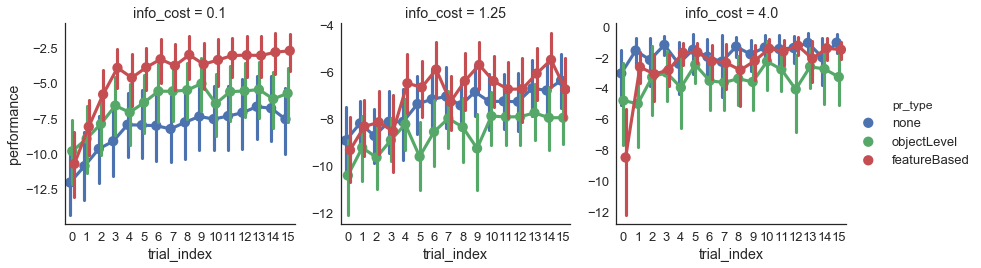

In [972]:
sns.factorplot('trial_index', 'performance', hue='pr_type', col='info_cost',
               data=df, dodge=.3, sharey=False)

In [25]:
g = df.groupby(['info_cost', 'trial_id']).regret
df['regret_z'] = g.apply(lambda x: (x - x.mean()) / x.std())
first = df.groupby('pid').regret_z.first()
df['regret_z_diff'] = df.regret_z - first[df.pid].as_matrix()

AttributeError: 'DataFrameGroupBy' object has no attribute 'regret'

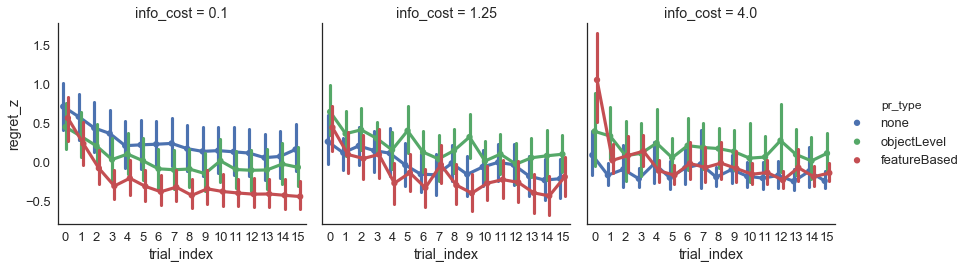

In [970]:
sns.factorplot('trial_index', 'regret_z', hue='pr_type', col='info_cost',
               data=df, dodge=.3, estimator=np.mean, markers='.')

## Relative score

In [415]:
cd ../mcrl

/home/fredcallaway/mcrl


In [29]:
from evaluation import evaluate
from model_utils import read_bo_policy, make_envs 
from policies import FixedPlanPolicy

term_action = 17

def test(cost):
    policies = {
        'BO': read_bo_policy(cost),
#         'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
        'full-observation': FixedPlanPolicy(range(1, term_action+1)),
        'none': FixedPlanPolicy([term_action]),
    }
    envs = make_envs(cost, n=16, ground_truth=1, sample_term_reward=True)
    def loop():
        for name, pol in policies.items():
            for _ in range(30):
                df = evaluate(pol, envs)
                df['agent'] = name
                df['trial_id'] = range(16)
                df['cost'] = cost
                yield df
    return pd.concat(loop())

jobs = (delayed(test)(c) for c in df.info_cost.unique())
mdf = pd.concat(Parallel(3)(jobs))

JoblibFileNotFoundError: JoblibFileNotFoundError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x107362db0, file "/usr...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/miniconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/l.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x107362db0, file "/usr...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/miniconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/l.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from evaluation import evaluate\nfrom model_utils...cost.unique())\nmdf = pd.concat(Parallel(3)(jobs))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 25, 20, 50, 57, 205088, tzinfo=tzutc()), 'msg_id': '0B9C526D7BA840E1850B570F3FDF0B5B', 'msg_type': 'execute_request', 'session': 'DB85CD4ED5224D289B356CCC5D1FFD71', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '0B9C526D7BA840E1850B570F3FDF0B5B', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'DB85CD4ED5224D289B356CCC5D1FFD71']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from evaluation import evaluate\nfrom model_utils...cost.unique())\nmdf = pd.concat(Parallel(3)(jobs))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 25, 20, 50, 57, 205088, tzinfo=tzutc()), 'msg_id': '0B9C526D7BA840E1850B570F3FDF0B5B', 'msg_type': 'execute_request', 'session': 'DB85CD4ED5224D289B356CCC5D1FFD71', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '0B9C526D7BA840E1850B570F3FDF0B5B', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'DB85CD4ED5224D289B356CCC5D1FFD71'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from evaluation import evaluate\nfrom model_utils...cost.unique())\nmdf = pd.concat(Parallel(3)(jobs))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 25, 20, 50, 57, 205088, tzinfo=tzutc()), 'msg_id': '0B9C526D7BA840E1850B570F3FDF0B5B', 'msg_type': 'execute_request', 'session': 'DB85CD4ED5224D289B356CCC5D1FFD71', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '0B9C526D7BA840E1850B570F3FDF0B5B', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from evaluation import evaluate\nfrom model_utils...cost.unique())\nmdf = pd.concat(Parallel(3)(jobs))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from evaluation import evaluate\nfrom model_utils...cost.unique())\nmdf = pd.concat(Parallel(3)(jobs))'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from evaluation import evaluate\nfrom model_utils...cost.unique())\nmdf = pd.concat(Parallel(3)(jobs))',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from evaluation import evaluate\nfrom model_utils...cost.unique())\nmdf = pd.concat(Parallel(3)(jobs))',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from evaluation import evaluate\nfrom model_utils...cost.unique())\nmdf = pd.concat(Parallel(3)(jobs))', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.FunctionDef object>, <_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-29-59aabc8545ee>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 121523fd0, execution_..._before_exec=None error_in_exec=None result=None>)
   2797 
   2798         try:
   2799             for i, node in enumerate(to_run_exec):
   2800                 mod = ast.Module([node])
   2801                 code = compiler(mod, cell_name, "exec")
-> 2802                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1215f6660, file "<ipython-input-29-59aabc8545ee>", line 26>
        result = <ExecutionResult object at 121523fd0, execution_..._before_exec=None error_in_exec=None result=None>
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1215f6660, file "<ipython-input-29-59aabc8545ee>", line 26>, result=<ExecutionResult object at 121523fd0, execution_..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1215f6660, file "<ipython-input-29-59aabc8545ee>", line 26>
        self.user_global_ns = {'Agent': <class 'agents.Agent'>, 'Counter': <class 'collections.Counter'>, 'FixedPlanPolicy': <class 'policies.FixedPlanPolicy'>, 'In': ['', "get_ipython().magic('matplotlib inline')\n\nimport...ils import *\nfrom joblib import Parallel, delayed", 'def load(v):\n    """Loads data from experiment w...a = df.pr_data.fillna(\'None\').apply(literal_eval)', 'def load(v):\n    """Loads data from experiment w...a = df.pr_data.fillna(\'None\').apply(literal_eval)', "df['rank'] = df.groupby(['info_cost', 'trial_id']).score.rank(pct=True)", "sns.factorplot('trial_index', 'score', hue='pr_t...ata=df, dodge=.3, estimator=np.mean, markers='.')", "g = df.groupby(['info_cost', 'trial_id']).score\n...z'] = g.apply(lambda x: (x - x.mean()) / x.std())", "g = df.groupby(['info_cost', 'trial_id']).score\n...z_diff'] = df.score_z - first[df.pid].as_matrix()", "sns.factorplot('trial_index', 'score_z', hue='pr...ata=df, dodge=.3, estimator=np.mean, markers='.')", "import rpy2.robjects as ro\nfrom rpy2.robjects im...i2py\nget_ipython().magic('load_ext rpy2.ipython')", r"get_ipython().run_cell_magic('R', '', 'library(lme4)\nlibrary(car)')", "cols = 'rank info_cost score score_z score_z_dif...split()\nrdf = df[cols].query('info_cost == 1.25')", r"get_ipython().run_cell_magic('R', '-i rdf', 'm =...trial_index + (1|trial_id), data=rdf)\nAnova(m)')", r"get_ipython().run_cell_magic('R', '-i rdf', 'm =..._z ~ pr_type * trial_index, data=rdf)\nAnova(m)')", r"get_ipython().run_cell_magic('R', '-i rdf', 'm =...pe * trial_index + (1|pid), data=rdf)\nAnova(m)')", "sys.path.append('../mcrl/')\nfrom model_utils imp...functions import LiederQ\nfrom agents import Agent", "sys.path.append('../mcrl/python')\nfrom model_uti...functions import LiederQ\nfrom agents import Agent", "get_ipython().magic('ls ../mcrl/python')", "get_ipython().magic('ls .')", "get_ipython().magic('ls ../')", ...], 'Labeler': <class 'utils.Labeler'>, 'LiederQ': <class 'value_functions.LiederQ'>, 'Out': {5: <seaborn.axisgrid.FacetGrid object>, 8: <seaborn.axisgrid.FacetGrid object>}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'PriorityQueue': <class 'utils.PriorityQueue'>, 'Qs': {'0.10': <value_functions.LiederQ object>, '1.25': <value_functions.LiederQ object>, '4.00': <value_functions.LiederQ object>}, ...}
        self.user_ns = {'Agent': <class 'agents.Agent'>, 'Counter': <class 'collections.Counter'>, 'FixedPlanPolicy': <class 'policies.FixedPlanPolicy'>, 'In': ['', "get_ipython().magic('matplotlib inline')\n\nimport...ils import *\nfrom joblib import Parallel, delayed", 'def load(v):\n    """Loads data from experiment w...a = df.pr_data.fillna(\'None\').apply(literal_eval)', 'def load(v):\n    """Loads data from experiment w...a = df.pr_data.fillna(\'None\').apply(literal_eval)', "df['rank'] = df.groupby(['info_cost', 'trial_id']).score.rank(pct=True)", "sns.factorplot('trial_index', 'score', hue='pr_t...ata=df, dodge=.3, estimator=np.mean, markers='.')", "g = df.groupby(['info_cost', 'trial_id']).score\n...z'] = g.apply(lambda x: (x - x.mean()) / x.std())", "g = df.groupby(['info_cost', 'trial_id']).score\n...z_diff'] = df.score_z - first[df.pid].as_matrix()", "sns.factorplot('trial_index', 'score_z', hue='pr...ata=df, dodge=.3, estimator=np.mean, markers='.')", "import rpy2.robjects as ro\nfrom rpy2.robjects im...i2py\nget_ipython().magic('load_ext rpy2.ipython')", r"get_ipython().run_cell_magic('R', '', 'library(lme4)\nlibrary(car)')", "cols = 'rank info_cost score score_z score_z_dif...split()\nrdf = df[cols].query('info_cost == 1.25')", r"get_ipython().run_cell_magic('R', '-i rdf', 'm =...trial_index + (1|trial_id), data=rdf)\nAnova(m)')", r"get_ipython().run_cell_magic('R', '-i rdf', 'm =..._z ~ pr_type * trial_index, data=rdf)\nAnova(m)')", r"get_ipython().run_cell_magic('R', '-i rdf', 'm =...pe * trial_index + (1|pid), data=rdf)\nAnova(m)')", "sys.path.append('../mcrl/')\nfrom model_utils imp...functions import LiederQ\nfrom agents import Agent", "sys.path.append('../mcrl/python')\nfrom model_uti...functions import LiederQ\nfrom agents import Agent", "get_ipython().magic('ls ../mcrl/python')", "get_ipython().magic('ls .')", "get_ipython().magic('ls ../')", ...], 'Labeler': <class 'utils.Labeler'>, 'LiederQ': <class 'value_functions.LiederQ'>, 'Out': {5: <seaborn.axisgrid.FacetGrid object>, 8: <seaborn.axisgrid.FacetGrid object>}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'PriorityQueue': <class 'utils.PriorityQueue'>, 'Qs': {'0.10': <value_functions.LiederQ object>, '1.25': <value_functions.LiederQ object>, '4.00': <value_functions.LiederQ object>}, ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/Users/fred/Projects/mcrl/experiments/<ipython-input-29-59aabc8545ee> in <module>()
     21                 df['cost'] = cost
     22                 yield df
     23     return pd.concat(loop())
     24 
     25 jobs = (delayed(test)(c) for c in df.info_cost.unique())
---> 26 mdf = pd.concat(Parallel(3)(jobs))

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=3), iterable=<generator object <genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=3)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
FileNotFoundError                                  Mon Dec 25 12:50:57 2017
PID: 40568               Python 3.6.3: /usr/local/lib/miniconda3/bin/python
...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function test>, (1.25,), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function test>
        args = (1.25,)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/fred/Projects/mcrl/experiments/<ipython-input-29-59aabc8545ee> in test(cost=1.25)
      4 
      5 term_action = 17
      6 
      7 def test(cost):
      8     policies = {
----> 9         'BO': read_bo_policy(cost),
     10 #         'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
     11         'full-observation': FixedPlanPolicy(range(1, term_action+1)),
     12         'none': FixedPlanPolicy([term_action]),
     13     }

...........................................................................
/Users/fred/Projects/mcrl/python/model_utils.py in read_bo_policy(cost=1.25, note='')
     49 
     50 def read_bo_result(cost, note=''):
     51     return skopt.load(filename(cost, note))
     52 
     53 def read_bo_policy(cost, note=''):
---> 54     result = read_bo_result(cost, note)
        result = undefined
        cost = 1.25
        note = ''
     55     return LiederPolicy(result.specs['info']['theta'])
     56 
     57 ENV = make_env(0)
     58 

...........................................................................
/Users/fred/Projects/mcrl/python/model_utils.py in read_bo_result(cost=1.25, note='')
     46     if note:
     47         note += '_'
     48     return f'data/policy_{note}{c}.pkl'
     49 
     50 def read_bo_result(cost, note=''):
---> 51     return skopt.load(filename(cost, note))
        cost = 1.25
        note = ''
     52 
     53 def read_bo_policy(cost, note=''):
     54     result = read_bo_result(cost, note)
     55     return LiederPolicy(result.specs['info']['theta'])

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/skopt/utils.py in load(filename='data/policy_1.25.pkl', **kwargs={})
    169     Returns
    170     -------
    171     * `res` [`OptimizeResult`, scipy object]:
    172         Reconstructed OptimizeResult instance.
    173     """
--> 174     return load_(filename, **kwargs)
        filename = 'data/policy_1.25.pkl'
        kwargs = {}
    175 
    176 
    177 def is_listlike(x):
    178     return isinstance(x, (list, tuple))

...........................................................................
/usr/local/lib/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py in load(filename='data/policy_1.25.pkl', mmap_mode=None)
    562 
    563     if hasattr(filename, "read") and hasattr(filename, "seek"):
    564         with _read_fileobject(filename, "", mmap_mode) as fobj:
    565             obj = _unpickle(fobj)
    566     else:
--> 567         with open(filename, 'rb') as f:
        filename = 'data/policy_1.25.pkl'
        f = undefined
    568             with _read_fileobject(f, filename, mmap_mode) as fobj:
    569                 if isinstance(fobj, _basestring):
    570                     # if the returned file object is a string, this means we
    571                     # try to load a pickle file generated with an version of

FileNotFoundError: [Errno 2] No such file or directory: 'data/policy_1.25.pkl'
___________________________________________________________________________

In [417]:
xdf = mdf.groupby('agent cost trial_id'.split())[['observations', 'util']].mean()
x = df.apply(lambda row: xdf.loc['BO', row.info_cost, row.trial_id], axis=1)
df['lc_score'] = x.util
df['relative_score'] = df.score - df.lc_score
df['lc_clicks'] = x.observations
df['relative_clicks'] = df.n_click - df.lc_clicks

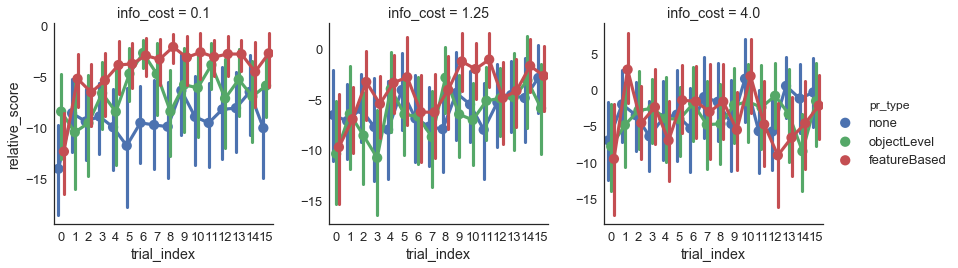

In [973]:
sns.factorplot('trial_index', 'relative_score', hue='pr_type', col='info_cost',
               data=df, dodge=.4, sharey=False)

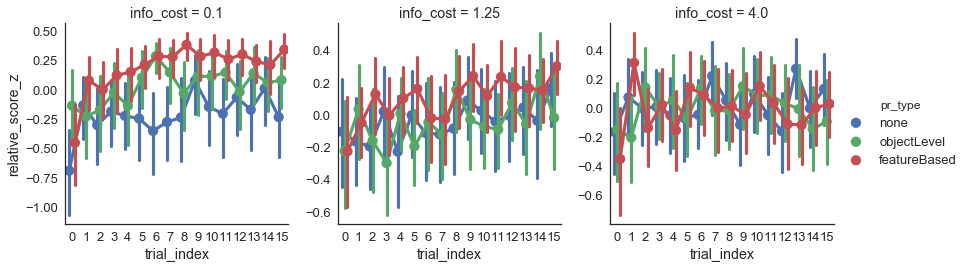

In [974]:
g = df.groupby(['info_cost', 'trial_id']).relative_score
df['relative_score_z'] = g.apply(lambda x: (x - x.mean()) / x.std())
sns.factorplot('trial_index', 'relative_score_z', hue='pr_type', col='info_cost',
               data=df, dodge=.4, sharey=False)

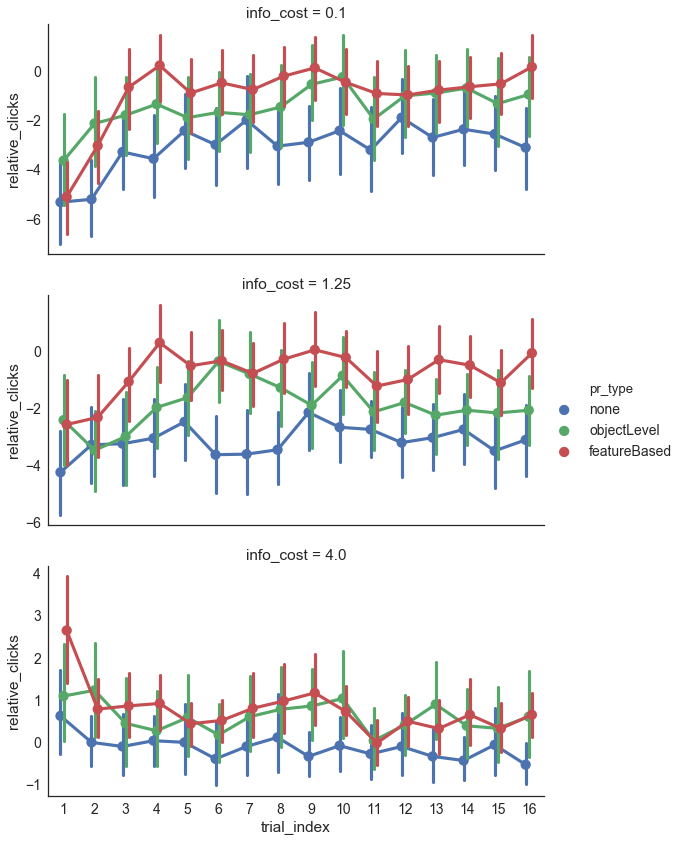

In [58]:
sns.factorplot('trial_index', 'relative_clicks', hue='pr_type', row='info_cost',
               data=df,
               aspect=2, dodge=.4, sharey=False)

# Bayesian data analysis

In [419]:
from pymc3 import *
import theano.tensor as tt
from theano.printing import Print

In [147]:
import warnings
warnings.simplefilter("ignore")
from collections import namedtuple
Result = namedtuple('Result', ['model', 'trace', 'MAP'])

def exponential_learning(t, low, high, rate, max_t):
    alpha = rate / (high - low)
    beta = (high - low) / (1 - tt.exp(-alpha * max_t))
    return low + beta * (1 - tt.exp(-alpha * t))

def model(df, ignore_pr=False):
    # Indices and dimensions.
    pid = df.pidx.as_matrix()  # participant id
    n_pid = pid.max() + 1
    stim = df.trial_id.as_matrix()
    n_stim = stim.max() + 1
    if ignore_pr:
        pr_type = np.zeros(len(df), dtype=int)
        n_pr = 1
    else:
        pr_type = df.pr_type.apply(pr_types.index).as_matrix()
        n_pr = len(pr_types)
    trial = df.trial_index.as_matrix()
    n_trial = trial.max() + 1
    cost = df.info_cost.apply(info_costs.index).as_matrix()
    n_cost = len(info_costs)
    
    with Model() as model:
        # Group level parameters.
        low = 0
        high = Exponential('high', 1, shape=(n_cost, n_pr))
        rate = Exponential('rate', 1, shape=(n_cost, n_pr))
        
        # Stimuli parameters.
        sigma = HalfCauchy('sigma', beta=10., shape=(n_cost, n_stim))
        baseline = Normal('baseline', 0, 100, shape=(n_cost, n_stim))
        
        # Generative model.
        t = np.arange(n_trial).reshape(-1, 1, 1)  # broadcasting
        skill = Deterministic('skill', exponential_learning(t, low, high, rate, n_trial-1))
        pred_score = Deterministic('pred_score', baseline[cost, stim] +
                                                 skill[trial, cost, pr_type] *
                                                 sigma[cost, stim])
        score = Normal('score', pred_score, sigma[cost, stim], 
                       observed=df.score.as_matrix())
        MAP = find_MAP()
        return Result(model, sample(500, njobs=22), MAP)

    
results = [model(df)]
# pmean = {k: trace[k].mean(0) for k in trace.varnames}

NameError: name 'Model' is not defined

In [749]:
import pymc3 as pm
tbl = pm.compare([r.trace for r in results], [r.model for r in results])
tbl

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
0,59643.7,145.7,0,0.94,173.76,0,1
1,59709.1,138.36,65.39,0.06,175.04,17.4,1


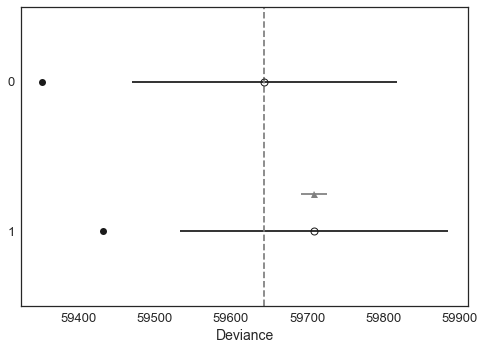

In [750]:
pm.compareplot(tbl)

In [598]:
[pm.dic(r.trace, r.model) for r in results]

[60311.413406433036, 60331.270738896026]

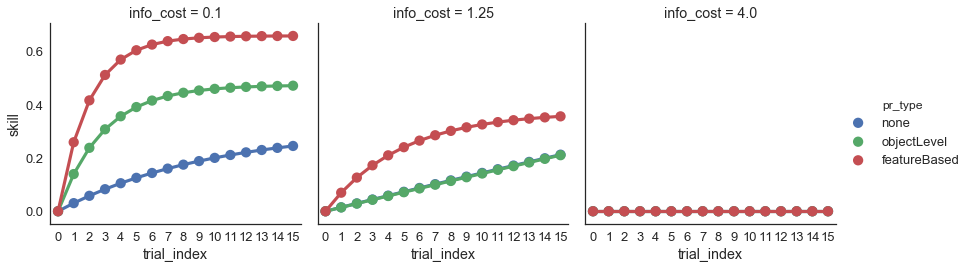

In [708]:
def plot_map_skill(MAP):
    idx = pd.MultiIndex.from_product([trials, info_costs, pr_types], 
                                     names=['trial_index', 'info_cost', 'pr_type'])
    df = pd.DataFrame({'skill': MAP['skill'].flatten()}, index=idx).reset_index()
    sns.factorplot('trial_index', 'skill', hue='pr_type', col='info_cost', data=df)

model, trace, MAP = results[0]
plot_map_skill(MAP)

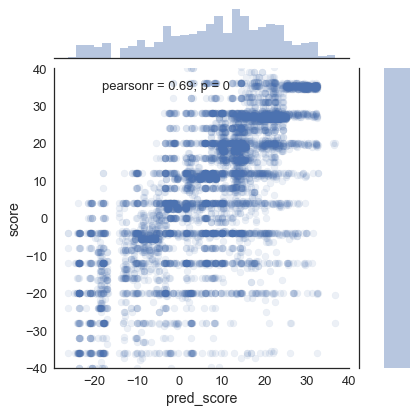

In [507]:
sns.jointplot('pred_score', 'score', data=df, joint_kws=dict(alpha=0.1))
plt.xlim(-40, 40)
plt.ylim(-40, 40)
plt.gca().set_aspect('equal')

In [711]:
def var_df(var):
    panel = pd.Panel(trace[var], major_axis=info_costs, minor_axis=pr_types)
    frame = pd.melt(panel.to_frame().reset_index(),  id_vars=['major', 'minor'])
    frame = frame.rename(columns={'major': 'info_cost', 'minor': 'pr_type', 'variable': 'sample'})
    frame['var'] = var
    return frame

varnames = ['high', 'rate']
tdf = pd.concat(var_df(v) for v in varnames)

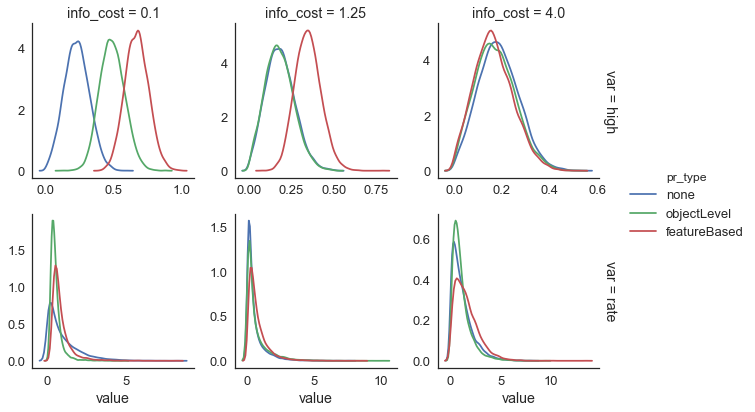

In [712]:
g = sns.FacetGrid(tdf, col='info_cost', row='var', hue='pr_type',
                  sharex=False, sharey=False, margin_titles=True)
g.map(sns.distplot, 'value', hist=False)
g.add_legend();

In [715]:
for var, vdf in tdf.groupby('var'):
    print(var)
    for cost, cdf in vdf.groupby('info_cost'):
        print(' ', cost)
        samples = cdf.set_index('pr_type').value
        def compare(a, b):
            prob = np.mean(samples[a].as_matrix() < samples[b].as_matrix())
            print(f'    P({a:12} < {b:12}) = {prob:.3f}')
        a,b,c = pr_types
        compare(a, b)
        compare(a, c)
        compare(b, c)

high
  0.1
    P(none         < objectLevel ) = 0.999
    P(none         < featureBased) = 1.000
    P(objectLevel  < featureBased) = 0.993
  1.25
    P(none         < objectLevel ) = 0.486
    P(none         < featureBased) = 0.976
    P(objectLevel  < featureBased) = 0.978
  4.0
    P(none         < objectLevel ) = 0.410
    P(none         < featureBased) = 0.365
    P(objectLevel  < featureBased) = 0.455
rate
  0.1
    P(none         < objectLevel ) = 0.415
    P(none         < featureBased) = 0.550
    P(objectLevel  < featureBased) = 0.739
  1.25
    P(none         < objectLevel ) = 0.523
    P(none         < featureBased) = 0.661
    P(objectLevel  < featureBased) = 0.621
  4.0
    P(none         < objectLevel ) = 0.485
    P(none         < featureBased) = 0.628
    P(objectLevel  < featureBased) = 0.651


In [731]:
samples = np.arange(len(trace['skill']))
idx = pd.MultiIndex.from_product([samples, trials, info_costs, pr_types],
                                 names=['sample', 'trial_index', 'info_cost', 'pr_type'])
sdf = pd.DataFrame({'skill': trace['skill'].flatten()}, index=idx).skill.reset_index()

In [735]:
sk = sdf.query('trial_index > 10').set_index(['pr_type', 'info_cost', 'trial_index', 'sample']).skill
d1 = (sk['featureBased'] > sk['none']).mean(level=[0])
d2 = (sk['featureBased'] > sk['objectLevel']).mean(level=[0])
print(pd.DataFrame({'meta > none': d1, 'meta > object': d2}))

           meta > none  meta > object
info_cost                            
0.10          1.000000       0.995945
1.25          0.987709       0.988291
4.00          0.368709       0.457200


In [752]:
sk = sdf.set_index(['pr_type', 'info_cost', 'trial_index', 'sample']).skill
(sk['featureBased'] > sk['none']).mean(level=[0,1])

info_cost  trial_index
0.10       0              0.000000
           1              0.989909
           2              1.000000
           3              1.000000
           4              1.000000
           5              1.000000
           6              1.000000
           7              1.000000
           8              1.000000
           9              1.000000
           10             1.000000
           11             1.000000
           12             1.000000
           13             1.000000
           14             1.000000
           15             1.000000
1.25       0              0.000000
           1              0.911182
           2              0.953182
           3              0.978182
           4              0.989455
           5              0.995273
           6              0.998182
           7              0.999000
           8              0.998909
           9              0.998636
           10             0.998091
           11             0.9962

In [885]:
sk = trace['skill'].mean(0)
skh = pm.hpd(trace['skill'])
sk.shape, skh.shape

((16, 3, 3), (16, 3, 3, 2))

In [886]:
lower = skh[:, :, :, 0]
mean = sk
upper = skh[:, :, :, 1]

idx = pd.MultiIndex.from_product([trials, info_costs, pr_types],
                                 names=['trial_index', 'info_cost', 'pr_type'])
lower = pd.Series(lower.ravel(), index=idx)
upper = pd.Series(upper.ravel(), index=idx)
est = pd.Series(mean.ravel(), index=idx)

In [887]:
hdf = pd.DataFrame({
    'lower': lower,
    'upper': upper,
    'est': est
}).reset_index()

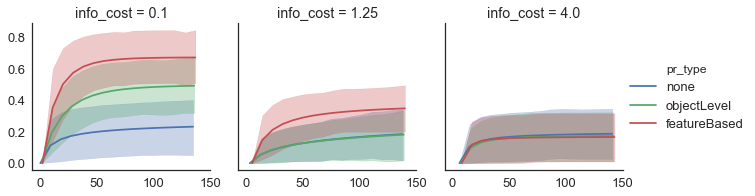

In [891]:
g = sns.FacetGrid(hdf, col='info_cost', hue='pr_type', aspect=1)

def plot(data, color, label):
#     offset = [0, 0.3, 0.6][pr_types.index(label)]
#     idx = data.index + offset
#     plt.errorbar(idx, data.est, [data.lower, data.upper], c=color, label=label,  elinewidth=1, linewidth=2)
    plt.plot(data.index, data.est, c=color, label=label)
    plt.fill_between(data.index, data.lower, data.upper, color=color, alpha=0.3)

g.map_dataframe(plot)
g.add_legend();

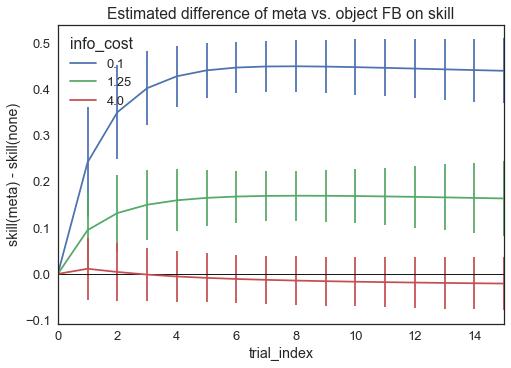

In [754]:
d1 = (sk['featureBased'] - sk['none']).groupby(level=[0, 1])
d1.mean().unstack().T.plot(yerr=d1.std().unstack().T)
plt.ylabel('skill(meta) - skill(none)')
plt.title('Estimated difference of meta vs. object FB on skill')
plt.axhline(0, c='k', lw=1)

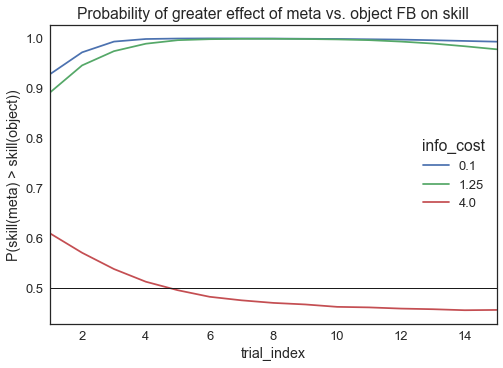

In [764]:
sk = sdf.query('trial_index > 0')

sk = sk.set_index(['pr_type', 'info_cost', 'trial_index', 'sample']).skill
d1 = (sk['featureBased'] > sk['objectLevel']).groupby(level=[0, 1])
d1.mean().unstack().T.plot()
plt.ylabel('P(skill(meta) > skill(object))')
plt.title('Probability of greater effect of meta vs. object FB on skill')
plt.axhline(0.5, c='k', lw=1)

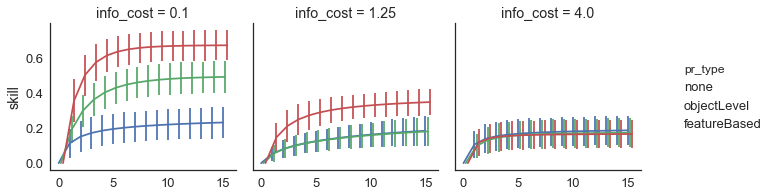

In [748]:
g = sns.FacetGrid(sdf, col='info_cost', hue='pr_type', aspect=1)

def plot(data, color, label):
    sk = data.groupby('trial_index').skill
    mean = sk.mean()
    std = sk.std()
    offset = [0, 0.2, 0.4][pr_types.index(label)]
    idx = mean.index + offset
    plt.errorbar(idx, mean, std, c=color)
#     mean.plot(yerr=std, label=label, c=color, )
#     plt.plot(idx, mean, c=color, label=label)
#     plt.fill_between(idx, mean-std, mean+std, color=color, alpha=0.2)
#     sk.mean().plot(yerr=sk.std(), c=color, label=label)

g.map_dataframe(plot)
g.add_legend();
g.axes.flat[0].set_ylabel('skill')

In [379]:
def sample_curves(thin=10):
    dd = df.copy()
    chains = trace.get_values('skill', combine=False)
    for ci, samples in enumerate(chains):
        for si in range(0, len(samples), thin):
            dd['skill'] = samples[si]
            skill = dd.groupby('pr_type trial_index'.split()).skill.mean().reset_index()
            skill['ci'] = ci
            skill['si'] = si
            yield skill

skill = pd.concat(sample_curves())

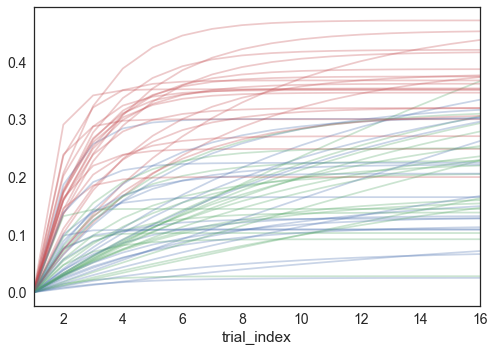

In [380]:
cmap = dict(zip(pr_types, sns.color_palette()))
for ci in skill.ci.unique():
    x = skill.query('ci == @ci and si == 490')
    for pr, dd in x.groupby('pr_type'):
        dd.set_index('trial_index').skill.plot(c=cmap[pr], alpha=0.3)

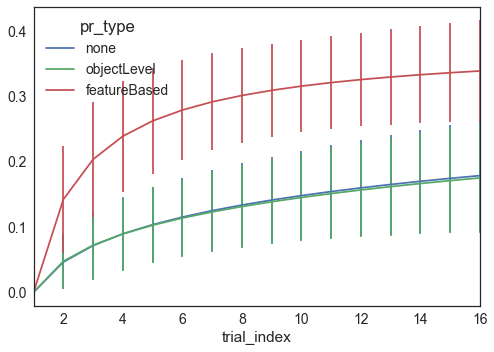

In [381]:
g = skill.groupby(['pr_type', 'trial_index'])

mean = g.skill.mean().unstack().T
std = g.skill.std().unstack().T
mean.plot(yerr=std)

# plot()


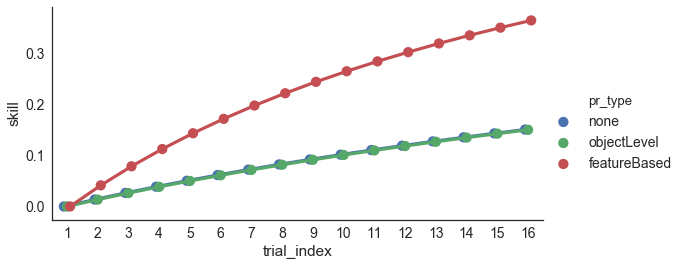

In [314]:
sns.factorplot('trial_index', 'skill', hue='pr_type', data=skill,
               aspect=2, dodge=.2)

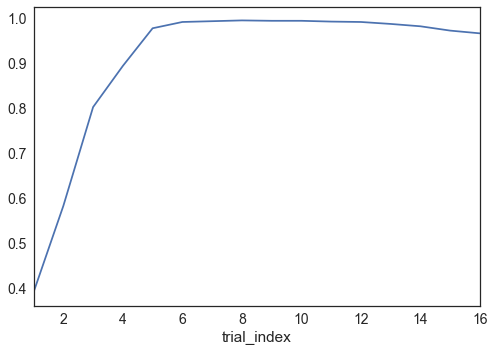

In [273]:
sk = skill.set_index(['pr_type', 'trial_index']).skill
((sk['none'] < sk['featureBased'])
 .reset_index()
 .groupby('trial_index')
 .skill
 .mean()
 .loc[3:]
 .mean()
 .plot()
)
# mean()


1.0428967216 -2.10456727025 -0.903627192269
0.815207965151 -2.57896872297 -0.960240049129
1.04782892702 5.35293502018 1.34158370506


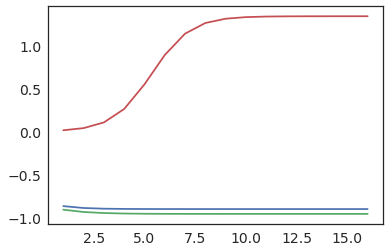

In [267]:
def logistic(x, k=1, x0=0, L=1):
    return L / (1 + np.exp(-k * (x - x0)))

t = df.trial_index.unique()
for pr, k, x0, L in zip(pr_types, *get('b_k b_x0 b_L'.split(), mle)):
#     if pr ==  'featureBased':
#         continue
    print(k, x0, L)
    plt.plot(t, logistic(t, k, x0, L))

# Exploratory

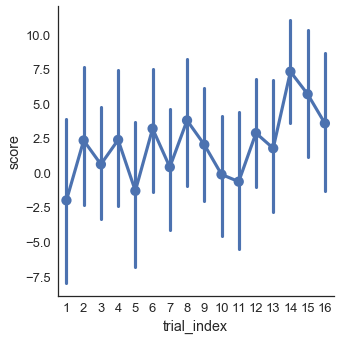

In [291]:
# sns.lmplot('trial_index', 'score', data=df, lowess=1, scatter_kws=dict(alpha=0))
# plt.ylim(-10, 10)
df.trial_index = df.trial_index.astype(int)
sns.factorplot('trial_index', 'score', data=df, size=5)


In [134]:
pdf.groupby(['message', 'PR_type']).apply(len)

message  PR_type     
full     featureBased    35
none     none            41
dtype: int64

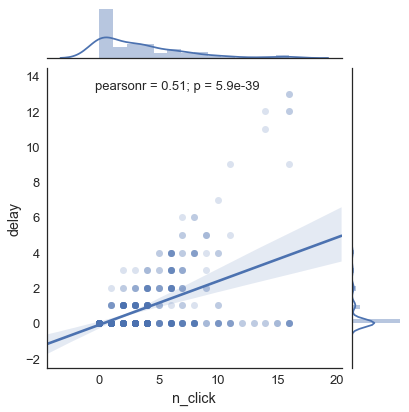

In [119]:
sns.jointplot('n_click', 'delay', data=df, kind='reg', scatter_kws=dict(alpha=0.2))

In [211]:
# df['over_plan'] = df.planned_too_much.apply(literal_eval).apply(sum)
# df['over_plan'] = df.planned_too_much.apply(literal_eval).apply(get(0, default=0)).apply(int)
df['over_plan'] = df.planned_too_much.apply(literal_eval).apply(sum)
df['under_plan'] = df.planned_too_little.apply(literal_eval).apply(get(0, default=0)).apply(int)
df['delay'] = df.delays.apply(get(0, default=0))
df['total_delay'] = df.delays.apply(sum)
# sns.factorplot('trial_index', 'over_plan', data=df)
# df.groupby('trial_index')[['over_plan', 'under_plan', 'delay']].mean().loc[:10].plot()

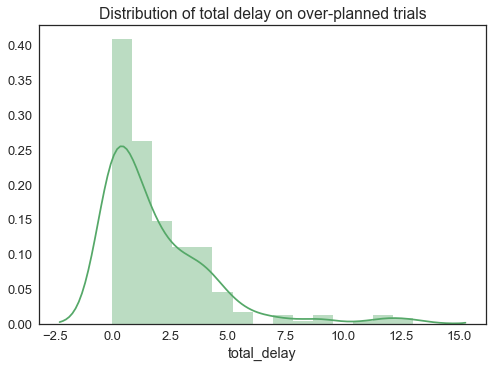

In [217]:
sns.distplot(df.query('over_plan > 0').total_delay, color='g')
plt.title('Distribution of total delay on over-planned trials')

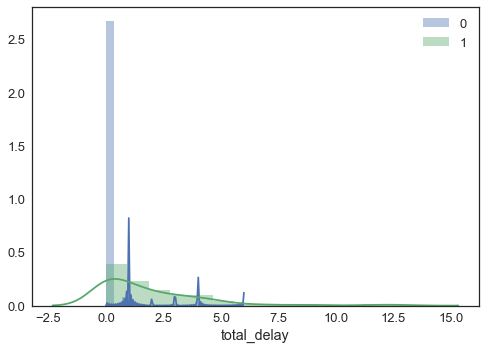

In [203]:
# sns.factorplot('over_plan', 'total_delay', data=df)
for op, dd in df.groupby('over_plan'):
    sns.distplot(dd.total_delay, label=str(op))
plt.legend()

In [101]:
sympy.init_printing()

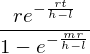

In [112]:
import sympy
t, low, high, rate, max_t = sympy.symbols('t l h r m')

def exponential_learning(t, low, high, rate, max_t):
    alpha = rate / (high - low)
    beta = (high - low) / (1 - sympy.exp(-alpha * max_t))
    return low + beta * (1 - sympy.exp(-alpha * t))

sympy.diff(exponential_learning(t, low, high, rate, max_t), t)

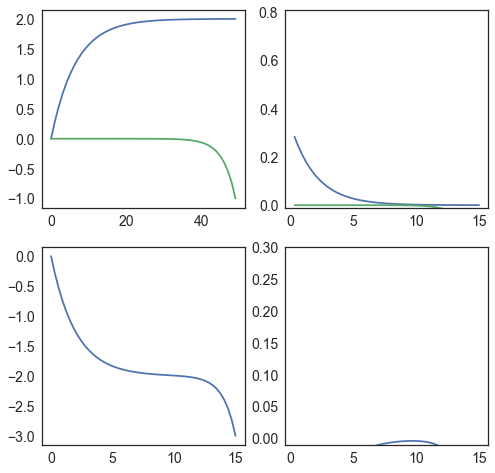

In [155]:
def exponential_learning(t, low, high, rate, max_t):
    alpha = rate
    alpha = rate / (high - low)
    beta = (high - low) / (1 - np.exp(-alpha * max_t))
    return low + beta * (1 - np.exp(-alpha * t))

x = np.linspace(0, 15)
ys = [
    exponential_learning(x, 0, 2, 1, 15),
    exponential_learning(x, 0, -1, 1, 15),
]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for y in ys:
    axes[0, 0].plot(y)
    axes[0, 1].plot(x[1:], np.diff(y))
axes[1, 0].plot(x, ys[1] - ys[0])
axes[1, 1].plot(x[1:], np.diff(ys[1]) - np.diff(ys[0]))
axes[1, 1].set_ylim(-.01, .3)
axes[0, 1].set_ylim(-.01, .81);

In [118]:
def exponential_rise(x, low, high, rate):
    return low + (high - low) * (1 - tt.exp(-rate * x))

def model(df):
    # Indices and dimensions.
    pid = df.pidx.as_matrix()  # participant id
    n_pid = pid.max() + 1
    stim = df.trial_id.as_matrix()
    n_stim = stim.max() + 1
    pr_type = df.pr_type.apply(pr_types.index).as_matrix()
    n_pr = 3
    trial = (df.trial_index - 1).as_matrix()
    n_trial = trial.max() + 1
    
    with Model() as model:
        # Group level parameters.
        low = Uniform('low', -1, 1)
        high = Uniform('high', low, 1, shape=n_pr)
#         low = low[pr_type]
        high = high[pr_type]
        rate = Exponential('rate', n_trial, shape=n_pr)[pr_type]
        
        std_stim = HalfCauchy('std_stim', beta=10., shape=n_stim)[stim]
        
#         pr_effect = Normal('pr_effect', 0, 10, shape=(n_pr, n_trial))[pr_type, trial]
#         pred_score = Deterministic('pred_score', L_stim + pr_effect)
        
        # Generative model.
        skill = Deterministic('skill', exponential_rise(trial, low, high, rate))
#         improvement = logistic(trial, x0, k, L - baseline_pid)
#         skill = Deterministic('skill', baseline_pid + improvement)
        pred_score = Deterministic('pred_score', skill * df.lc_score.as_matrix())
        score = Normal('score', pred_score, std_stim, 
                       observed=df.score.as_matrix())
    
        return sample(500, njobs=22)
    
df = full_df.query('info_cost == 1.25').copy()
trace = model(df)
mle = {k: trace[k].mean(0) for k in trace.varnames}

low
  P(none         < objectLevel ) = 0.224
  P(none         < featureBased) = 0.699
  P(objectLevel  < featureBased) = 0.863
high
  P(none         < objectLevel ) = 0.484
  P(none         < featureBased) = 0.719
  P(objectLevel  < featureBased) = 0.732
rate
  P(none         < objectLevel ) = 0.630
  P(none         < featureBased) = 0.737
  P(objectLevel  < featureBased) = 0.638


In [691]:
import warnings
warnings.simplefilter("ignore")
from collections import namedtuple
Result = namedtuple('Result', ['model', 'trace', 'MAP'])

def exponential_learning(t, low, high, rate, max_t):
    beta = (high - low) / (1 - tt.exp(-rate * max_t))
    return low + beta * (1 - tt.exp(-rate * t))

def model(df, ignore_pr=False):
    # Indices and dimensions.
    pid = df.pidx.as_matrix()  # participant id
    n_pid = pid.max() + 1
    stim = df.trial_id.as_matrix()
    n_stim = stim.max() + 1
    if ignore_pr:
        pr_type = np.zeros(len(df), dtype=int)
        n_pr = 1
    else:
        pr_type = df.pr_type.apply(pr_types.index).as_matrix()
        n_pr = len(pr_types)
    trial = df.trial_index.as_matrix()
    n_trial = trial.max() + 1
    cost = df.info_cost.apply(info_costs.index).as_matrix()
    n_cost = len(info_costs)
    
    with Model() as model:
        # Group level parameters.
        low = HalfNormal('low', sd=10, shape=(n_cost, n_pr))
        improvement = Uniform('improvement', 0, low, shape=(n_cost, n_pr))
        high = Deterministic('high', low - improvement)
        rate = Exponential('rate', 1, shape=(n_cost, n_pr))
        
        # Stimuli parameters.
        sigma = HalfCauchy('sigma', beta=10., shape=(n_cost, n_stim))
        baseline = Normal('baseline', 0, 10, shape=(n_cost, n_stim))
        
        # Generative model.
        t = np.arange(n_trial).reshape(-1, 1, 1)  # broadcasting
        skill = Deterministic('skill', exponential_learning(t, low, high, rate, n_trial-1))
        pred_regret = Deterministic('pred_regret', baseline[cost, stim] +
                                                   skill[trial, cost, pr_type] *
                                                   sigma[cost, stim])
        regret = Normal('regret', pred_regret, sigma[cost, stim], 
                       observed=df.regret.as_matrix())
        MAP = find_MAP()
        return Result(model, sample(500, njobs=22), MAP)


results = [model(df)]
# pmean = {k: trace[k].mean(0) for k in trace.varnames}

logp = nan, ||grad|| = 57.566: 100%|██████████| 278/278 [00:00<00:00, 496.37it/s] 
100%|██████████| 1000/1000 [02:48<00:00,  5.92it/s]


In [257]:
def logistic(x, k=1, x0=0, L=1):
    return L / (1 + tt.exp(-k * (x - x0)))

def model(df):
    # Indices and dimensions.
    pid = df.pidx.as_matrix()  # participant id
    n_pid = pid.max() + 1
    stim = df.trial_id.as_matrix()
    n_stim = stim.max() + 1
    pr_type = df.pr_type.apply(pr_types.index).as_matrix()
    n_pr = 3
    trial = (df.trial_index).as_matrix()
    n_trial = trial.max() + 1
    
    with Model() as model:
        # Group level parameters.
        L = Normal('L', 0, 10, shape=n_pr)[pr_type]
        x0 = Normal('x0', 0, 10, shape=n_pr)[pr_type]
        k = Exponential('k', 1, shape=n_pr)[pr_type]

        # Participant level parameters.
#         baseline_pid = Normal('baseline_pid', 0, 10, shape=n_pid)[pid]
        baseline_pid = 0

        # Stimulus parameters.
        L_stim = Normal('L_stim', df.score.mean(), 100, shape=n_stim)[stim]
        std_stim = HalfCauchy('std_stim', beta=10., shape=n_stim)[stim]
        
#         pr_effect = Normal('pr_effect', 0, 10, shape=(n_pr, n_trial))[pr_type, trial]
#         pred_score = Deterministic('pred_score', L_stim + pr_effect)
        
        # Generative model.
        improvement = logistic(trial, x0, k, L - baseline_pid)
        skill = Deterministic('skill', baseline_pid + improvement)
        pred_score = Deterministic('pred_score', L_stim + std_stim * skill)
        score = Normal('score', pred_score, std_stim, 
                       observed=df.performance.as_matrix())
    
        return sample(500, njobs=23)
    
trace = model(df.query('info_cost == 1.25').copy())
mle = {k: trace[k].mean(0) for k in trace.varnames}

 32%|███▏      | 321/1000 [01:52<03:57,  2.86it/s]/home/fredcallaway/miniconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.535474282606, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/fredcallaway/miniconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 1 contains 73 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 40%|███▉      | 395/1000 [02:32<03:52,  2.60it/s]/home/fredcallaway/miniconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 9 does not match the target. It is 0.933882794169, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
 45%|██

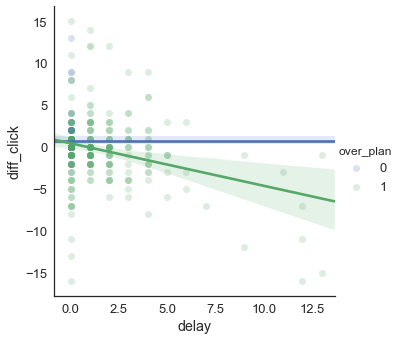

In [184]:
df['next_score'] = [0] + list(df.score[:-1])
df['next_click'] = [0] + list(df.n_click[:-1])
df['diff_click'] = df.next_click - df.n_click
sns.lmplot('delay', 'diff_click', hue='over_plan', 
           data=df.query('trial_index < 11 and PR_type == "featureBased"'),
           scatter_kws=dict(alpha=0.2), )

# Generate files

In [14]:
cols = ('pid info_cost PR_type message trial_index trial_i delays '
        'score n_click clicks click_times path action_times'
        .split())
df[cols].to_csv('data/human/{}/trials.csv'.format(VERSION))

In [271]:
identifiers = pd.read_csv('data/human_raw/{}/identifiers.csv'.format(VERSION))
pdf = pd.read_csv('data/human/{}/participants.csv'.format(VERSION))
pdf = pdf.join(identifiers.set_index('pid'))
pdf.bonus
# xx = pdf.set_index('worker_id')[['score', 'return_time', 'test_idx']]
# xx['test_idx'] = [[0,1,2,3,4,5]]
# xx.to_json('exp1/static/json/stage1.json',orient='index')

# (pd.read_csv('data/human/{}/survey-text.csv'.format(VERSION))
#  .responses.apply(literal_eval).apply(get('Q0')))

0    3.33
1    1.73
Name: bonus, dtype: float64

In [35]:
from toolz import *

df['info_cost'] = list(pdf.info_cost[df.pid])
def write_state_actions():
    for cost, dd in df.groupby('info_cost'):
        data = {}
        data['states'] = list(concat(dd.beliefs))
        data['actions'] = list(concat(dd.meta_actions))
        with open(f'../python/data/state_actions_{cost:.2f}.json', 'w+') as f:
            json.dump(data, f)
        
write_state_actions()
    

FileNotFoundError: [Errno 2] No such file or directory: '../python/data/state_actions_0.10.json'

In [71]:
DEBUG = []
def parse_row(row):
    times = row.action_times + row.click_times
    acts = row.actions + row.clicks
    try:
        sorted_acts = np.array(acts)[np.argsort(times)]
    except:
        DEBUG.append(row)
        return None
    for a in sorted_acts:
        try:
            state = int(a)
        except:
            state = None
        yield {'is_click': state is not None,
               'move': a if state is None else None,
               'state': state}
        
from analysis_utils import *

for pid, dd in df.groupby('pid'):
    cond = pdf.condition[pid]
    dd = dd.sort_values('trial_i')
    # trace = list(filter(None, rowapply(dd, compose(list, parse_row))))
    trace = list(rowapply(dd, compose(list, parse_row)))
    path = 'data/human/{}/traces/{}/'.format(VERSION, cond)
    os.makedirs(path, exist_ok=True)
    with open(path + '{}.json'.format(pid), 'w+') as f:
        json.dump(trace, f)

In [72]:
df = df.drop(df[df.click_times.apply(lambda x: None in x)].index)
def click_then_move(row):
    return max(row.click_times, default=-1) < min(row.action_times)

np.mean(rowapply(df, click_then_move))

0.75949754901960786

In [14]:
VERSION = '1A.1'
errors = []
sys.path.append('bin')
from compensation import Compensator
comp = Compensator()
identifiers = pd.read_csv('data/human_raw/{}/identifiers.csv'.format(VERSION))
pdf = pd.read_csv('data/human/{}/participants.csv'.format(VERSION))
pdf = pdf.join(identifiers.set_index('pid'))

True

In [180]:
for i, row in pdf.iterrows():
    # comp.approve(row.assignment_id)
    if row.bonus > 0:
        result = comp.grant_bonus(row.worker_id, row.assignment_id, round(row.bonus, 2))
        if result:
            errors.append(result)

Compensator: Skipping previously bonused worker A10ZKWRZ8WL775
Compensator: Skipping previously bonused worker A112V6HAH568DI
Compensator: Skipping previously bonused worker A11ASDVMEEIYZE
Compensator: Skipping previously bonused worker A11WXSQQRJGQDR
Compensator: Skipping previously bonused worker A12WRJ2ZMDW3SU
Compensator: Skipping previously bonused worker A136WVBAZDIVLZ
Compensator: Skipping previously bonused worker A16AFSPBIJC9CA
Compensator: Skipping previously bonused worker A17KSIKT9ZPR75
Compensator: Skipping previously bonused worker A17M78CCTQFUAO
Compensator: Skipping previously bonused worker A17UTAVQMEF94Z
Compensator: Skipping previously bonused worker A18FVXL05I2YEO
Compensator: Skipping previously bonused worker A19RNVJ2IO0HCS
Compensator: Skipping previously bonused worker A1ADGLKC2F1CHS
Compensator: Skipping previously bonused worker A1AXJTLZGJ42MV
Compensator: Skipping previously bonused worker A1B0D5F4TC9FMI
Compensator: Skipping previously bonused worker A1BABC5

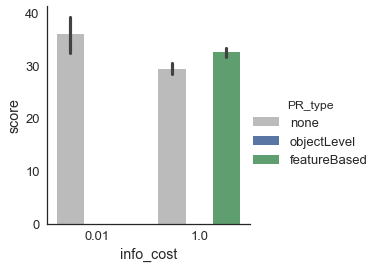

In [76]:
PALETTE = ['#bbbbbb'] + sns.palettes.SEABORN_PALETTES['deep']
sns.set_palette(PALETTE)
PR_ORDER = 'none objectLevel featureBased'.split()
# PR_ORDER = ['objectLevel', 'featureBased']

sns.factorplot('info_cost', 'score', hue='PR_type', data=df, 
               kind='bar', hue_order=PR_ORDER)

In [80]:
def comparison(kind):
    comp = pd.read_csv('data/stimuli/exp1/{}.csv'.format(kind), header=None)
    comp.columns = INFO_COSTS
    return comp
    return comp.stack()
    return comp.stack()[df[['trial_i', 'info_cost']].as_matrix()]

c = comparison('optimal')

In [78]:
INFO_COSTS = [0.01, 1.00, 2.50]
# INFO_COSTS = pdf.info_cost.unique()
dd = df.copy()
def comparison(kind):
    comp = pd.read_csv('data/stimuli/exp1/{}.csv'.format(kind), header=None)
    comp.columns = INFO_COSTS
    return list(comp[1.0].loc[df.trial_i])
    return comp.stack()[df[['trial_i', 'info_cost']].as_matrix()]

df['optimal'] = comparison('optimal')
df['worst'] = comparison('worst')

# df['optimal'] = list(optimal.loc[df.trial_i])
df['regret'] = df.score - df.optimal
df['trial_mean'] = list(df.groupby('trial_i').score.mean().loc[df.trial_i])
df['centered_score'] = df.score - df.trial_mean

# (R-R_min)/(R_max-R_min)
df['relative_score'] = (df.score - df.worst) / (df.optimal - df.worst)

In [88]:
def hamming_distance(s1, s2):
    assert(len(s1) == len(s2))
    dif = 0
    for i in range(len(s1)):
        if s1[i] != s2[i]:
            dif += 1

    return dif

def foobar(s1, s2):
    return sum(1 for c1, c2 in zip(s1, s2)
               if c1 != c2)

In [103]:
df['condition'] = pdf.PR_type.apply(lambda x: 'constant' if x == 'none' else 'pseudo') + '_' + pdf.message

In [278]:

sns.lmplot('trial_index', 'score', hue='message', col='PR_type', data=df,
           size=4, sharey=True, lowess=True, scatter=0)

KeyError: "['PR_type' 'message'] not in index"

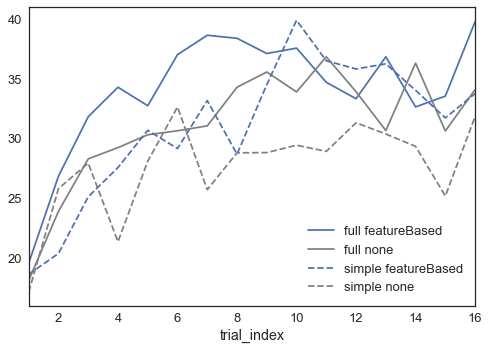

In [101]:
# dd = df.set_index('trial_index')
def plot():
    ax = plt.gca()
    pr_c = {'none': 'gray', 'featureBased': 'b'}
    msg_ls = {'simple': '--', 'full': '-'}
    dd = df.groupby(['message', 'PR_type', 'trial_index']).score.mean()
    for (m, p), dd in df.groupby(['message', 'PR_type']):
        try:
            dd.groupby('trial_index').score.mean().plot(
                ax=ax, c=pr_c[p], ls=msg_ls[m], label='{} {}'.format(m, p))
        except:
            pass
    plt.legend()
plot()


In [89]:
sns.lmplot('trial_index', 'relative_score', hue='PR_type', data=df,
               col='info_cost', size=4, sharey=False, lowess=True, scatter=0,
               hue_order=PR_ORDER, palette=PALETTE)

NameError: name 'PR_ORDER' is not defined

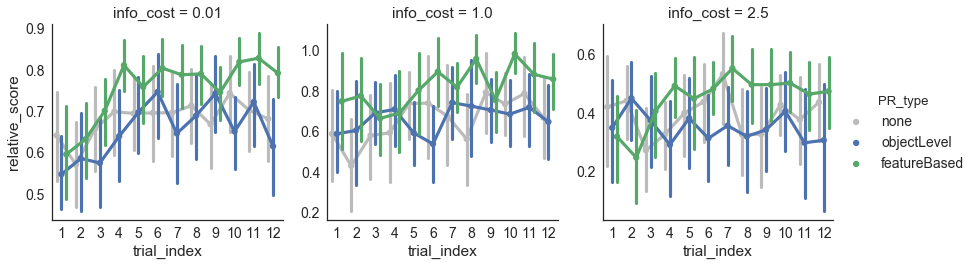

In [27]:
sns.factorplot('trial_index', 'relative_score', hue='PR_type', data=df,
               col='info_cost', size=4, sharey=False,
               dodge=.5, markers='.', ci=95, estimator=np.mean,
               hue_order=PR_ORDER, palette=PALETTE)

In [11]:
cols = [
    'info_cost',
    'relative_score',
    'trial_index',
    'score',
    'n_click',
    'pid',
    'trial_i',
    'PR_type',
    'test',
    'message'
]
rdf = df2r(df, cols)

KeyError: "['relative_score'] not in index"

In [178]:
%%R -i rdf
require(lme4)
require(car)
require(lsmeans)
# rdf$info_cost = as.factor(rdf$info_cost)
m = Anova(lmer('score ~ trial_index * PR_type * message + (1|pid) + (1|trial_i)', 
          data=rdf,
           # data=subset(rdf, info_cost == .01)
                      ))
m

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: score
                              Chisq Df Pr(>Chisq)    
trial_index                 39.4779  1  3.318e-10 ***
PR_type                      4.5890  1   0.032178 *  
message                      9.5945  1   0.001952 ** 
trial_index:PR_type          1.3766  1   0.240677    
trial_index:message          0.0483  1   0.826118    
PR_type:message              1.7674  1   0.183701    
trial_index:PR_type:message  0.0122  1   0.911898    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [10]:
%%R -i rdf
Anova(lm
      ('score ~ condition', 
           data=subset(rdf, trial_index == 1)
                      ))

NameError: name 'rdf' is not defined

In [222]:
pdf.groupby('condition')[['PR_type', 'message']].apply(lambda x: x.iloc[0])

,PR_type,message
condition,,
0,none,full
1,none,simple
2,featureBased,full
3,featureBased,simple


In [217]:
%%R -i rdf
Anova(lm
      ('score ~ message * PR_type', 
           data=subset(rdf, trial_index == 1)
                      ))

Anova Table (Type II tests)

Response: score
                Sum Sq  Df F value  Pr(>F)  
message             35   1  0.0936 0.75997  
PR_type           1015   1  2.7350 0.09983 .
message:PR_type    344   1  0.9259 0.33715  
Residuals        70133 189                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [206]:
df.query('trial_index == 1').groupby('condition').n_click.mean()

condition
constant_full      3.80
constant_simple    7.75
pseudo_full        4.50
pseudo_simple      3.00
Name: n_click, dtype: float64

In [198]:
%%R
print('no feedback')
m = Anova(lmer('score ~ PR_type * message + (1|pid) + (1|trial_i)', 
#           data=rdf,
           data=subset(rdf, test==1)
                      ))
print(m)
print('feedback')
m = Anova(lmer('score ~ PR_type * message + (1|pid) + (1|trial_i)', 
#           data=rdf,
           data=subset(rdf, test==0)
                      ))
print(m)

[1] "no feedback"
Analysis of Deviance Table (Type II Wald chisquare tests)

Response: score
                 Chisq Df Pr(>Chisq)  
PR_type         1.2818  1    0.25757  
message         6.4725  1    0.01096 *
PR_type:message 2.0792  1    0.14932  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "feedback"
Analysis of Deviance Table (Type II Wald chisquare tests)

Response: score
                 Chisq Df Pr(>Chisq)   
PR_type         6.1773  1   0.012940 * 
message         7.9385  1   0.004839 **
PR_type:message 0.8277  1   0.362949   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [382]:
# from pymc3 import *

# with Model():
#     glm.GLM.from_formula('score ~ PR_type * trial_index', data=df)
#     start = find_MAP()
#     step = NUTS(scaling=start)
#     trace = sample(2000, step)
    

# full = t['PR_type[T.fullObservation]']
# none = t['PR_type[T.none]']
# (none > 0).mean()

Optimization terminated successfully.
         Current function value: 2314.381831

/usr/local/lib/miniconda3/lib/python3.5/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
  4%|▍         | 82/2000 [00:00<00:11, 173.13it/s]


         Iterations: 47
         Function evaluations: 55
         Gradient evaluations: 55
